# Simulation Pipeline for Hydrogen Simulation

In [1]:
# Simulation Imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import StatevectorSimulator, AerSimulator

from qiskit.quantum_info import Operator, Statevector
from qiskit import transpile, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram


# Internal Imports
from util import generateHamiltonian, getBuilderByType, generatePhaseEstimation#generateThetas


## Simplified Run Pipeline

In [8]:
# Constants
theta = [-1.5960928412985012, 0.3554257493027984, 0.34119476657602105, -0.4854856102628099, 0.3554257493027984, 0.24586610112367618, 0.35255281608639216, 0.0895002880307033, 0.0895002880307033, 0.3353663891543795, 0.24586610112367618, -0.4854856102628099, 0.0895002880307033, 0.0895002880307033, 0.3353663891543795]
initial_state = Statevector([0. +0.j, 1. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j,
                                     0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j,
                                     0. + 0.j, 0. + 0.j],
                                    dims=(2, 2, 2, 2))
builderType = "Steane" # Options: Physical, Double Spin, Steane, Heterogenous Surface
num_of_shots = 1
num_of_QPE_ancilla = 2
dt = 1

sim = AerSimulator(method='matrix_product_state')

print(theta)

[-1.5960928412985012, 0.3554257493027984, 0.34119476657602105, -0.4854856102628099, 0.3554257493027984, 0.24586610112367618, 0.35255281608639216, 0.0895002880307033, 0.0895002880307033, 0.3353663891543795, 0.24586610112367618, -0.4854856102628099, 0.0895002880307033, 0.0895002880307033, 0.3353663891543795]


In [ ]:
print(vars(sim.configuration()))

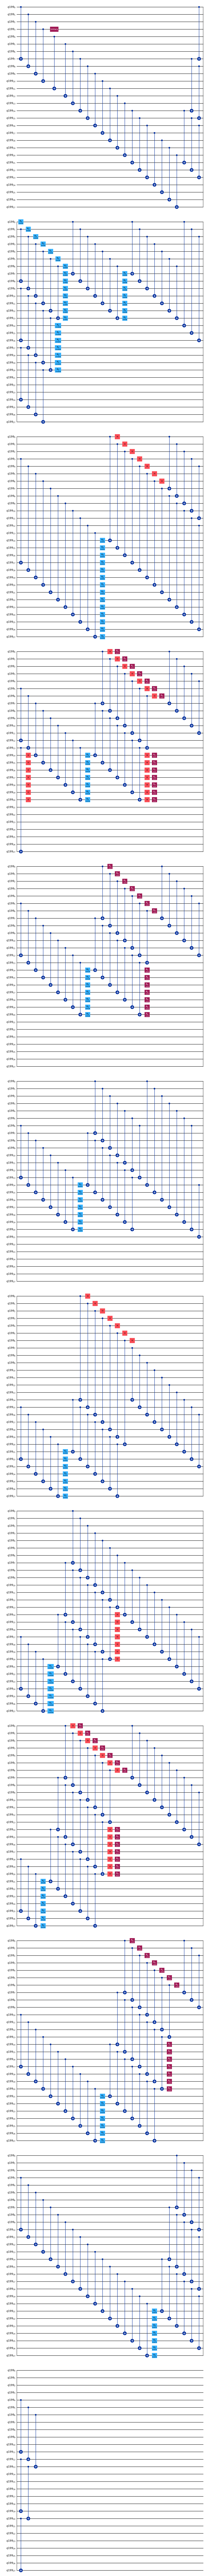

In [10]:
# Build the Circuit
hamiltonianBuilder = generateHamiltonian(theta, getBuilderByType(builderType))
plt.figure(hamiltonianBuilder.build().draw(output="mpl"))

initial_state =  Statevector([0. + 0.j, 1. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j,
                                     0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j,
                                     0. + 0.j, 0. + 0.j],
                                    dims=(2, 2, 2, 2))
"""
initial_state = Statevector([0. + 0.j, 0. + 0.j,0. + 0.j,1. + 0.j] + [0. + 0.j]*252)
"""
totalBuilder =  generatePhaseEstimation(num_of_QPE_ancilla, hamiltonianBuilder.getPhysicalNumber(), dt, hamiltonianBuilder, initial_state)

In [ ]:
# Run the Simulation
circuit = totalBuilder.build()
# Measure the ancilla qubits
circuit.measure(range(num_of_QPE_ancilla), range(num_of_QPE_ancilla))
#plt.figure(circuit.draw(output="mpl"))
compiled = transpile(circuit, sim)
job = sim.run(compiled, shots=num_of_shots)
result = job.result()
counts = result.get_counts()
most_frequent_result = max(counts.items(), key=lambda x: x[1])[0]
print(counts)
print(f"Most Frequent Result: {most_frequent_result}") #010011


## Vizualization of Results

### Ground State Energy

In [ ]:
enery_Kolos_upper = np.array([-1.12453881, -1.16493435, - 1.17234623, -1.17445199, -1.17447477, -1.17447498, -1.17446041 , -1.17285408, -1.16858212, -1.15506752, -1.13813155, -1.12013035, -1.10242011, -1.08578740, -1.07067758, -1.05731738, -1.04578647])

enery_Kolos_lower = np.array([-1.12453864, -1.16493411, -1.17234596, -1.17445199, -1.17447477, -1.17447466, -1.17446041 , -1.17285370, -1.16858164, -1.15506694, - 1.13813078, -1.12012903, -1.10241799, -1.08578400, -1.07067254, -1.05730948, -1.04577476])

enery_Kolos_mean = enery_Kolos_upper + enery_Kolos_lower
enery_Kolos_mean = enery_Kolos_mean/2


bond_lengths = np.array([1.0, 1.2, 1.3, 1.39, 1.4, 1.4011, 1.41, 1.5, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2])/2
energy_array = []
time = 1
for length in bond_lengths:
    theta, nuclear_repulsion_energy = generateThetas(length, time)
    hamiltonianBuilder = generateHamiltonian(theta, getBuilderByType(builderType))
    totalBuilder =  generatePhaseEstimation(num_of_QPE_ancilla, hamiltonianBuilder.getPhysicalNumber(), dt, hamiltonianBuilder.build(), initial_state)
    circuit = totalBuilder.build()
    # Measure the ancilla qubits
    circuit.measure(range(num_of_QPE_ancilla), range(num_of_QPE_ancilla))
    compiled = transpile(circuit, sim)
    job = sim.run(compiled, shots=num_of_shots)
    result = job.result()
    counts = result.get_counts()
    most_frequent_result = max(counts.items(), key=lambda x: x[1])[0]
    phase_decimal = int(most_frequent_result, 2) / (2 ** num_of_QPE_ancilla)
    energy = - phase_decimal * 2 * np.pi / time
    energy += nuclear_repulsion_energy
    print(f"Ground state energy at length {length}: {energy}") 
    energy_array.append(energy)

In [ ]:

plt.scatter(bond_lengths, energy_array, marker="o", label="This Study")
plt.scatter(bond_lengths, enery_Kolos_mean, marker = "D", label = "Kolos et al.")
plt.xlabel('Bond length [$\mathrm{\AA}$]')
plt.ylabel('Ground state energy [Hartree]')
plt.title('Ground State Energy Levels of Hydrogen Molecule System \nat Different Bond Lengths')
plt.legend()
plt.savefig('../groundEnergy2Spin.png')

In [ ]:
abs_diff = np.average(np.abs(energy_array - enery_Kolos_mean)) #Average absolute difference
print("Average absolute difference : ", abs_diff)
percentage_error = np.average(np.abs(np.divide(energy_array - enery_Kolos_mean, enery_Kolos_mean))) * 100
print("Percentage Error : ", percentage_error)

### Circuit Fidelity

### Statistical Invalid Codestate Detection

### Physical Gate Counts depending on encoding / computation time

In [ ]:
temp = getBuilderByType("steane")(4)
temp.initializeToLogicalGround(initial_state)
print(temp.build())

In [ ]:
print(circuit)

In [ ]:
list(range(0,5,-1))